<a href="https://colab.research.google.com/github/yeoneegit/final/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score,accuracy_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, Xception, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import cycle

In [ ]:
# 데이터 경로 설정
data_dir = './drive/MyDrive/bill/'
train_csv_path = data_dir + 'train.csv'
test_csv_path = data_dir + 'test.csv'
validation_csv_path = data_dir + 'validation.csv'

# CSV 파일 읽기
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
validation_df = pd.read_csv(validation_csv_path)

train_df = train_df.astype(str)
test_df = test_df.astype(str)
validation_df = validation_df.astype(str)


In [ ]:
# 이미지 전처리 설정
IMGSIZE = 256
BATCH_SIZE = 20
EPOCH = 100

# 이미지 recaling
train_datagen =  ImageDataGenerator(rescale=1. / 256)
test_datagen = ImageDataGenerator(rescale=1./256)
validation_datagen = ImageDataGenerator(rescale=1./256)


# 훈련 데이터에 대한 데이터 증강 설정(데이터 증강은 train에만)
train_datagen = ImageDataGenerator(
    rescale=1./256,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



# 훈련 데이터 제너레이터 생성
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = data_dir + 'train/',
    x_col='path',
    y_col='label',
    target_size=(IMGSIZE, IMGSIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# 검증 데이터 제너레이터 생성
val_generator = test_datagen.flow_from_dataframe(
    validation_df,
    directory = data_dir + 'validation/',
    x_col='path',
    y_col='label',
    target_size=(IMGSIZE, IMGSIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# 테스트 데이터 제너레이터 생성
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = data_dir + 'test/',
    x_col='path',
    y_col='label',
    target_size=(IMGSIZE, IMGSIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 200 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


In [ ]:
# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print("클래스 인덱스:", class_indices)

# 학습 및 검증 데이터셋의 클래스 개수 확인
num_classes = len(class_indices)
print("클래스 개수:", num_classes)

클래스 인덱스: {'0': 0, '1': 1}
클래스 개수: 2


----
# 📌 EfficinetNetB7
- optimizer : Adam
- learning rate = 0.001
- epochs = 100
- early stopping patience = 20

In [ ]:
optimizer = Adam(learning_rate=0.03)

base_model = EfficientNetB7(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMGSIZE, IMGSIZE, 3)))
base_model.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(5, 5))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# 모델 구조 확인
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_16 (Rescaling)    (None, 256, 256, 3)          0         ['input_9[0][0]']             
                                                                                                  
 normalization_8 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_16[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_17 (Rescaling)    (None, 256, 256, 3)          0         ['normalization_8[0][0]'

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=0, factor=0.5)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCH,
    validation_data = val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    callbacks=[reducelr, earlystop]
)

Epoch 1/100
10/10 [==============================] - 66s 4s/step - loss: 4.9099 - binary_accuracy: 0.4650 - val_loss: 0.6749 - val_binary_accuracy: 0.6000 - lr: 0.0300
Epoch 2/100
10/10 [==============================] - 38s 4s/step - loss: 0.7627 - binary_accuracy: 0.5350 - val_loss: 0.6787 - val_binary_accuracy: 0.6000 - lr: 0.0300
Epoch 3/100
10/10 [==============================] - 35s 4s/step - loss: 0.6986 - binary_accuracy: 0.5700 - val_loss: 0.6913 - val_binary_accuracy: 0.6000 - lr: 0.0150
Epoch 4/100
10/10 [==============================] - 37s 4s/step - loss: 0.6878 - binary_accuracy: 0.5650 - val_loss: 0.6922 - val_binary_accuracy: 0.6000 - lr: 0.0075
Epoch 5/100
10/10 [==============================] - 35s 4s/step - loss: 0.6898 - binary_accuracy: 0.5450 - val_loss: 0.6886 - val_binary_accuracy: 0.6000 - lr: 0.0037
Epoch 6/100
10/10 [==============================] - 34s 3s/step - loss: 0.6887 - binary_accuracy: 0.5900 - val_loss: 0.6877 - val_binary_accuracy: 0.6000 - lr:

In [ ]:
# accuracy 그래프 생성 함수
def plot_accuracy(history):

    plt.plot(history.history['binary_accuracy'],label='train accuracy')
    plt.plot(history.history['val_binary_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()


# loss 그래프 생성 함수
def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

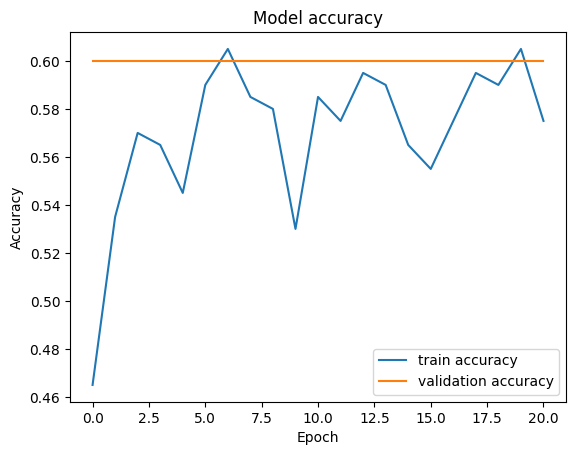

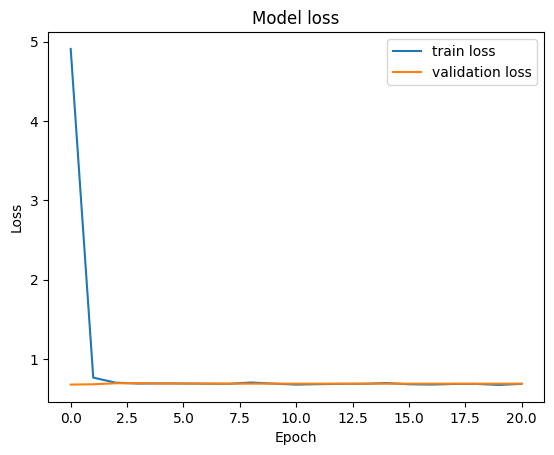

In [ ]:
plot_accuracy(history)
plot_loss(history)

In [ ]:

# test 데이터에 대한 예측
y_pred = model.predict_generator(test_generator)

# 이진 분류일 경우 예측값을 0 또는 1로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# 실제 라벨 가져오기
y_true = test_generator.classes

# classification report 출력
print(classification_report(y_true, y_pred_binary))

<ipython-input-33-50c25784170c>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.60      1.00      0.75        36

    accuracy                           0.60        60
   macro avg       0.30      0.50      0.37        60
weighted avg       0.36      0.60      0.45        60



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


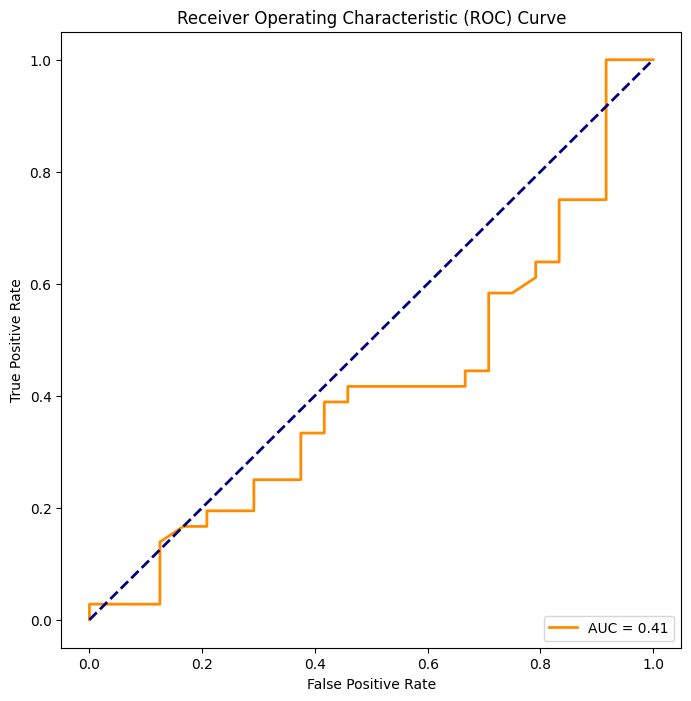

In [ ]:
# ROC 커브를 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

----
# 📌 ResNet101

In [ ]:
optimizer = Adam(learning_rate=0.03)

base_model = ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMGSIZE, IMGSIZE, 3)))
base_model.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(5, 5))(x)
x = Dropout(0.5)(x)
x = Flatten(name="flatten")(x)

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# 모델 구조 확인
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_13[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=0, factor=0.5)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCH,
    validation_data = val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    callbacks=[reducelr, earlystop]
)

Epoch 1/100
10/10 [==============================] - 44s 4s/step - loss: 1.1163 - binary_accuracy: 0.6100 - val_loss: 0.6005 - val_binary_accuracy: 0.6500 - lr: 0.0300
Epoch 2/100
10/10 [==============================] - 34s 3s/step - loss: 0.9153 - binary_accuracy: 0.5950 - val_loss: 0.4758 - val_binary_accuracy: 0.7250 - lr: 0.0300
Epoch 3/100
10/10 [==============================] - 35s 4s/step - loss: 0.5478 - binary_accuracy: 0.7050 - val_loss: 0.4041 - val_binary_accuracy: 0.8500 - lr: 0.0300
Epoch 4/100
10/10 [==============================] - 34s 3s/step - loss: 0.5586 - binary_accuracy: 0.7150 - val_loss: 0.6572 - val_binary_accuracy: 0.6000 - lr: 0.0300
Epoch 5/100
10/10 [==============================] - 34s 3s/step - loss: 0.5745 - binary_accuracy: 0.7350 - val_loss: 0.3246 - val_binary_accuracy: 0.9500 - lr: 0.0150
Epoch 6/100
10/10 [==============================] - 36s 4s/step - loss: 0.3961 - binary_accuracy: 0.8500 - val_loss: 0.3125 - val_binary_accuracy: 0.9750 - lr:

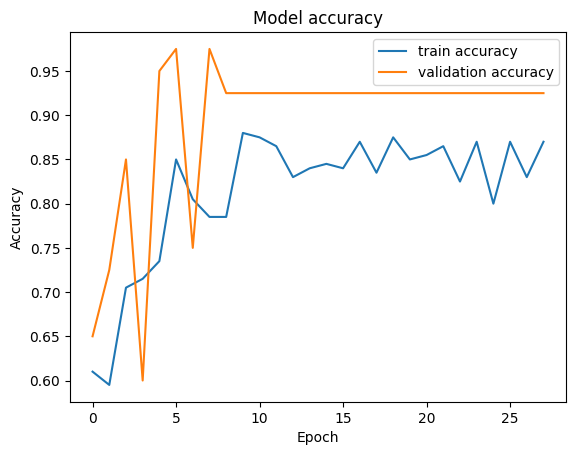

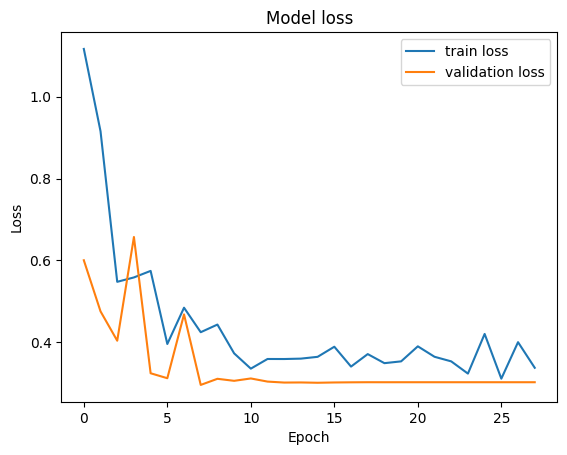

In [ ]:
plot_accuracy(history)
plot_loss(history)

In [ ]:
# test 데이터에 대한 예측
y_pred = model.predict_generator(test_generator)

# 이진 분류일 경우 예측값을 0 또는 1로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# 실제 라벨 가져오기
y_true = test_generator.classes

# classification report 출력
print(classification_report(y_true, y_pred_binary))

<ipython-input-46-50c25784170c>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


              precision    recall  f1-score   support

           0       0.24      0.25      0.24        24
           1       0.49      0.47      0.48        36

    accuracy                           0.38        60
   macro avg       0.36      0.36      0.36        60
weighted avg       0.39      0.38      0.39        60



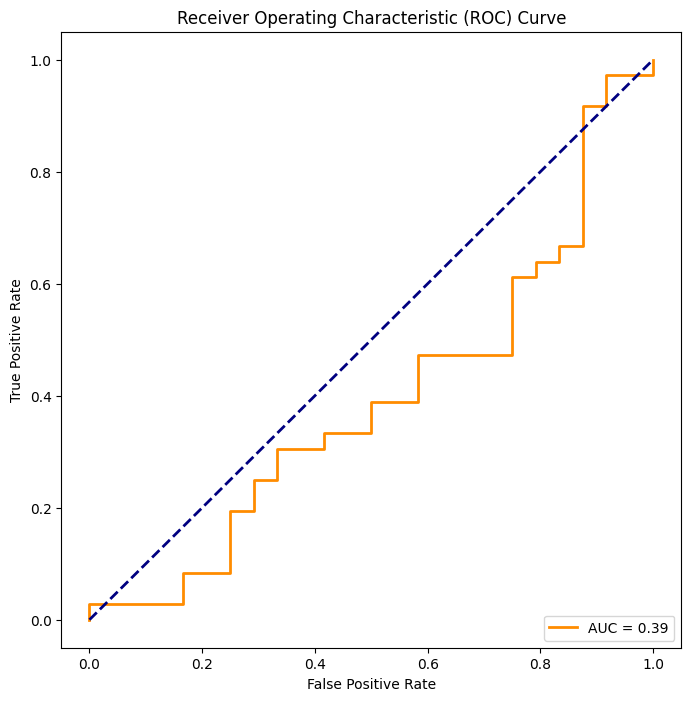

In [ ]:
# ROC 커브를 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

---
# 📌 VGG19

In [ ]:
optimizer = Adam(learning_rate=0.03)


base_model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMGSIZE, IMGSIZE, 3)))
base_model.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(5, 5))(x)
x = Dropout(0.6)(x)
x = Flatten(name="flatten")(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=0, factor=0.5)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCH,
    validation_data = val_generator,
    validation_steps = val_generator.samples // BATCH_SIZE,
    callbacks=[reducelr, earlystop]
)

In [ ]:
plot_accuracy(history)
plot_loss(history)

In [ ]:
# test 데이터에 대한 예측
y_pred = model.predict_generator(test_generator)

# 이진 분류일 경우 예측값을 0 또는 1로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# 실제 라벨 가져오기
y_true = test_generator.classes

# classification report 출력
print(classification_report(y_true, y_pred_binary))

In [ ]:
# ROC 커브를 계산
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()